In [20]:
# Load simulation data

import os
os.chdir('/home/scur2012/Thesis/master-thesis/experiments/network_training')

import zarr
import swyft.lightning as sl

zarr_store_dirs = '/scratch-shared/scur2012/peregrine_data/tmnre_experiments'
name_of_run = 'unet_lowSNR'

rnd_id = 1
simulation_store_path = f"{zarr_store_dirs}/{name_of_run}/simulations/round_{rnd_id}"

zarr_store = sl.ZarrStore(f"{simulation_store_path}")

simulation_results = zarr.convenience.open(simulation_store_path)

In [21]:
# Initialise dataloaders and setup trainer

BATCH_SIZE = 5

import torch
from torch import nn
torch.set_float32_matmul_precision('high')

train_data = zarr_store.get_dataloader(
    num_workers=8,
    batch_size=BATCH_SIZE,
    idx_range=[0, int(0.9 * len(zarr_store.data.z_int))],
    on_after_load_sample=False
)

val_data = zarr_store.get_dataloader(
    num_workers=8,
    batch_size=BATCH_SIZE,
    idx_range=[
        int(0.9 * len(zarr_store.data.z_int)),
        len(zarr_store.data.z_int) - 1,
    ],
    on_after_load_sample=None
)

In [22]:
# Settings for trainer and network

import importlib
import gw_parameters
importlib.reload(gw_parameters)

conf = gw_parameters.default_conf
bounds = gw_parameters.limits

intrinsic_variables = gw_parameters.intrinsic_variables
extrinsic_variables = gw_parameters.extrinsic_variables

In [23]:
# Define Inference network
import numpy as np
import swyft.lightning as sl
from toolz.dicttoolz import valmap
import torch.nn.functional as F

class InferenceNetwork(sl.SwyftModule):
    
    def __init__(self, **conf):
        super().__init__()
        self.one_d_only = conf["one_d_only"]
        self.batch_size = conf["training_batch_size"]
        self.noise_shuffling = conf["shuffling"]
        self.num_params = len(conf["priors"]["int_priors"].keys()) + len(
            conf["priors"]["ext_priors"].keys()
        )
        self.marginals = conf["marginals"]
        self.include_noise = conf["include_noise"]

        self.enet_t = ViT(
            seq_len = 8192,
            channels = 3,
            patch_size = 16,
            num_classes = 16,
            dim = 1024,
            depth = 6,
            heads = 8,
            mlp_dim = 2048,
            dropout = 0.1,
            emb_dropout = 0.1
        )
        
        self.enet_t = ViT(
            seq_len = 4096,
            channels = 6,
            patch_size = 16,
            num_classes = 16,
            dim = 1024,
            depth = 6,
            heads = 8,
            mlp_dim = 2048,
            dropout = 0.1,
            emb_dropout = 0.1
        )
        
        self.flatten = nn.Flatten(1)
        self.linear_t = LinearCompression()
        self.linear_f = LinearCompression()

        self.logratios_1d = sl.LogRatioEstimator_1dim(
            num_features=32, num_params=int(self.num_params), varnames="z_total"
        )
            
        self.optimizer_init = sl.AdamOptimizerInit(lr=conf["learning_rate"])

    def forward(self, A,B):        
        
        # A, B = self.get_A_B_samples(batch)
        
        if self.include_noise:
                   
            if self.noise_shuffling and A["d_t"].size(0) != 1:
                noise_shuffling = torch.randperm(self.batch_size)
                d_t = A["d_t"] + A["n_t"][noise_shuffling]
                d_f_w = A["d_f_w"] + A["n_f_w"][noise_shuffling]
            else:
                d_t = A["d_t"] + A["n_t"]
                d_f_w = A["d_f_w"] + A["n_f_w"]
        
        else:
            d_t = A["d_t"]
            d_f_w = A["d_f_w"]
        
        z_total = B["z_total"]

        features_t = self.ViT_t(d_t)
        features_f = self.ViT_f(d_f_w[:,:,:-1])
        
        # d_t = self.unet_t(d_t)
        # d_f_w = self.unet_f(d_f_w)
        # features_t = self.linear_t(self.flatten(d_t))
        # features_f = self.linear_f(self.flatten(d_f_w))
        
        features = torch.cat([features_t, features_f], dim=1)
        
        logratios_1d = self.logratios_1d(features, z_total)
        
        return logratios_1d
    
    def get_A_B_samples(self, batch):
        
        if isinstance(
            batch, list
        ):  # multiple dataloaders provided, using second one for contrastive samples
            A = batch[0]
            B = batch[1]
        else:  # only one dataloader provided, using same samples for constrative samples
            A = batch
            B = valmap(lambda z: torch.roll(z, 1, dims=0), A)

        # Concatenate positive samples and negative (contrastive) examples
        x = A
        z = {}
        for key in B:
            z[key] = torch.cat([A[key], B[key]])
            
        return x,z
            
    def training_step(self, batch, batch_idx):
        loss = self._calc_loss(batch)
        #self.log("train_loss", loss, on_step=True, on_epoch=False)
        return loss
            
    def validation_step(self, batch, batch_idx):
        loss = self._calc_loss(batch, randomized=False)
        # self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        # self.save_roc_curve(batch, batch_idx)
        
        return loss
    
    def predict_step(self, batch, *args, **kwargs):
        A = batch[0]
        B = batch[1]
        return self(A,B)
    
    def _calc_loss(self, batch, randomized=True):
        """Calculate batch-averaged loss summed over ratio estimators.

        Note: The expected loss for an untrained classifier (with f = 0) is
        subtracted.  The initial loss is hence usually close to zero.
        """
        A, B = self.get_A_B_samples(batch)

        num_pos = len(list(A.values())[0])  # Number of positive examples
        num_neg = len(list(B.values())[0]) - num_pos  # Number of negative examples

        out = self(A,B)  # Evaluate network
        loss_tot = 0

        logratios = self._get_logratios(
            out
        )  # Generates concatenated flattened list of all estimated log ratios
        if logratios is not None:
            y = torch.zeros_like(logratios)
            y[:num_pos, ...] = 1
            pos_weight = torch.ones_like(logratios[0]) * num_neg / num_pos
            loss = F.binary_cross_entropy_with_logits(
                logratios, y, reduction="none", pos_weight=pos_weight
            )
            num_ratios = loss.shape[1]
            loss = loss.sum() / num_neg  # Calculates batched-averaged loss
            loss = loss - 2 * np.log(2.0) * num_ratios
            loss_tot += loss

        aux_losses = self._get_aux_losses(out)
        if aux_losses is not None:
            loss_tot += aux_losses.sum()

        return loss_tot
    
    def get_logratios_probabilities(self, batch):
        
        A, B = self.get_A_B_samples(batch)

        num_pos = len(list(A.values())[0])  # Number of positive examples
        num_neg = len(list(B.values())[0]) - num_pos  # Number of negative examples

        out = self(A,B)  # Evaluate network

        logratios = self._get_logratios(
            out
        )  # Generates concatenated flattened list of all estimated log ratios
        
        if logratios is not None:
            y = torch.zeros_like(logratios)
            y[:num_pos, ...] = 1
            
        # Use soft-max to convert logratios to probabilities
        probabilities = nn.functional.softmax(logratios, dim=0)
        
        return logratios, probabilities, y

In [118]:
import torch.nn as nn
import torch


class InitialBlock(nn.Module):
    """The initial block is composed of two branches:
    1. a main branch which performs a regular convolution with stride 2;
    2. an extension branch which performs max-pooling.

    Doing both operations in parallel and concatenating their results
    allows for efficient downsampling and expansion. The main branch
    outputs 13 feature maps while the extension branch outputs 3, for a
    total of 16 feature maps after concatenation.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number output channels.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 downsample=2,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv1d(
            in_channels,
            out_channels - in_channels,
            kernel_size=downsample+1,
            stride=downsample,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool1d(downsample)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm1d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        print(main.shape)
        ext = self.ext_branch(x)
        print(ext.shape)
        # Concatenate branches
        out = torch.cat((main, ext), 1)
        print(out.shape)
        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    """Regular bottlenecks are the main building block of ENet.
    Main branch:
    1. Shortcut connection.

    Extension branch:
    1. 1x1 convolution which decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. regular, dilated or asymmetric convolution;
    3. 1x1 convolution which increases the number of channels back to
    ``channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - channels (int): the number of input and output channels.
    - internal_ratio (int, optional): a scale factor applied to
    ``channels`` used to compute the number of
    channels after the projection. eg. given ``channels`` equal to 128 and
    internal_ratio equal to 2 the number of channels after the projection
    is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension
    branch. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv1d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), 
            nn.BatchNorm1d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv1d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size),
                    stride=1,
                    padding=(padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm1d(internal_channels), activation(),
                nn.Conv1d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1),
                    stride=1,
                    padding=(0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm1d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv1d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm1d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv1d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm1d(channels), activation())

        self.ext_regul = nn.Dropout1d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    """Downsampling bottlenecks further downsample the feature map size.

    Main branch:
    1. max pooling with stride 2; indices are saved to be used for
    unpooling later.

    Extension branch:
    1. 2x2 convolution with stride 2 that decreases the number of channels
    by ``internal_ratio``, also called a projection;
    2. regular convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``channels``
    used to compute the number of channels after the projection. eg. given
    ``channels`` equal to 128 and internal_ratio equal to 2 the number of
    channels after the projection is 64. Default: 4.
    - return_indices (bool, optional):  if ``True``, will return the max
    indices along with the outputs. Useful when unpooling later.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 downsample=2,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool1d(
            downsample,
            #stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels,
                internal_channels,
                kernel_size=downsample+1,
                stride=downsample,
                padding=1,
                bias=bias), nn.BatchNorm1d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv1d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm1d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv1d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm1d(out_channels), activation())

        self.ext_regul = nn.Dropout1d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    """The upsampling bottlenecks upsample the feature map resolution using max
    pooling indices stored from the corresponding downsampling bottleneck.

    Main branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. max unpool layer using the max pool indices from the corresponding
    downsampling max pool layer.

    Extension branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. transposed convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``in_channels``
     used to compute the number of channels after the projection. eg. given
     ``in_channels`` equal to 128 and ``internal_ratio`` equal to 2 the number
     of channels after the projection is 64. Default: 4.
    - dropout_prob (float, optional): probability of an element to be zeroed.
    Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if ``True``.
    Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 upsample=2,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm1d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool1d(kernel_size=upsample)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm1d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose1d(
            internal_channels,
            internal_channels,
            kernel_size=upsample,
            stride=upsample,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm1d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv1d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm1d(out_channels))

        self.ext_regul = nn.Dropout1d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size=None):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class ENet(nn.Module):
    """Generate the ENet model.

    Keyword arguments:
    - num_classes (int): the number of classes to segment.
    - encoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the encoder blocks/layers; otherwise, PReLU
    is used. Default: False.
    - decoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the decoder blocks/layers; otherwise, PReLU
    is used. Default: True.

    """

    def __init__(
        self,
        in_channels=3,
        out_channels=1,
        downsample=2,
        upsample=2,
        encoder_relu=False, 
        decoder_relu=True):
        super().__init__()

        self.initial_block = InitialBlock(in_channels, 16, relu=encoder_relu, downsample=downsample)

        # Stage 1 - Encoder
        self.downsample1_0 = DownsamplingBottleneck(
            16,
            64,
            downsample=downsample,
            return_indices=True,
            dropout_prob=0.01,
            relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 - Encoder
        self.downsample2_0 = DownsamplingBottleneck(
            64,
            128,
            return_indices=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 3 - Encoder
        self.regular3_0 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_1 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_2 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_3 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular3_4 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_5 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_6 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_7 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 4 - Decoder
        self.upsample4_0 = UpsamplingBottleneck(
            128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0 = UpsamplingBottleneck(
            64, 16, dropout_prob=0.1, relu=decoder_relu, upsample=upsample)
        self.regular5_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv = nn.ConvTranspose1d(
            16,
            out_channels,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
            bias=False)

    def forward(self, x):
        print (x.shape)
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)
        print (x.shape)
        # Stage 1 - Encoder
        stage1_input_size = x.size()
        print('size',stage1_input_size)
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)
        print (x.shape)
        # Stage 2 - Encoder
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)
        print (x.shape)
        # Stage 3 - Encoder
        x = self.regular3_0(x)
        x = self.dilated3_1(x)
        x = self.asymmetric3_2(x)
        x = self.dilated3_3(x)
        x = self.regular3_4(x)
        x = self.dilated3_5(x)
        x = self.asymmetric3_6(x)
        x = self.dilated3_7(x)
        print (x.shape)
        # Stage 4 - Decoder
        x = self.upsample4_0(x, max_indices2_0, stage2_input_size)
        x = self.regular4_1(x)
        x = self.regular4_2(x)
        print (x.shape)
        # Stage 5 - Decoder
        x = self.upsample5_0(x, max_indices1_0, output_size=stage1_input_size)
        print (x.shape)
        x = self.regular5_1(x)
        print (x.shape)
        x = self.transposed_conv(x)
        print (x.shape)
        return x

In [127]:
model = ENet(in_channels = 6, downsample = 2, upsample=2)
x = model(batch['d_f_w'][:,:,:-1])

torch.Size([5, 6, 4096])
torch.Size([5, 10, 2048])
torch.Size([5, 6, 2048])
torch.Size([5, 16, 2048])
torch.Size([5, 16, 2048])
size torch.Size([5, 16, 2048])
torch.Size([5, 64, 1024])
torch.Size([5, 128, 512])
torch.Size([5, 128, 512])
torch.Size([5, 64, 1024])
torch.Size([5, 16, 2048])
torch.Size([5, 16, 2048])
torch.Size([5, 1, 4096])


In [108]:
upsample5_0 = UpsamplingBottleneck(
            64, 16, dropout_prob=0.1, relu=False)

In [109]:
y = torch.rand([5, 64, 128])
y.shape
upsample5_0(y, max).shape

TypeError: UpsamplingBottleneck.forward() missing 2 required positional arguments: 'max_indices' and 'output_size'

In [122]:
layer = nn.Sequential(
            nn.LazyLinear(1024),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(16),
        )

/home/scur2012/.conda/envs/peregrine/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [123]:
x.shape

torch.Size([5, 1, 2048])

In [125]:
layer(x).shape

torch.Size([5, 1, 16])

In [50]:
x.size()

torch.Size([5, 16, 8192])

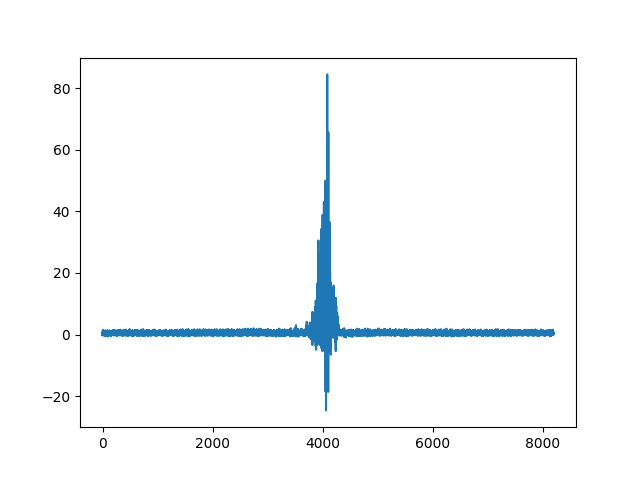

In [66]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.close('all')
plt.plot(x[0,0].detach().numpy())
plt.show()


In [33]:
x = batch['d_t']
print("Input:", x.shape)
for name, layer in model.named_children():
    x = layer(x)
    print(f"After {name}: {x.shape}")

Input: torch.Size([5, 3, 8192])
After initial_block: torch.Size([5, 16, 4096])


AttributeError: 'tuple' object has no attribute 'shape'

In [19]:
for batch in train_data:
    batch = {key:batch[key].to('cpu') for key in batch}
    break


In [103]:
# Initialise network

N_EPOCHS = 2
LR = 0.00005

network_settings = dict(
    # Peregrine
    shuffling = True,
    include_noise = True,
    priors = dict(
        int_priors = conf['priors']['int_priors'],
        ext_priors = conf['priors']['ext_priors'],
    ),
    marginals = ((0, 1),),
    one_d_only = True,
    ifo_list = conf["waveform_params"]["ifo_list"],
    learning_rate = LR,
    training_batch_size = BATCH_SIZE,
)

network = InferenceNetwork(**network_settings)

/home/scur2012/Thesis/master-thesis/.venv/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 2/2 loss: -1.09
Validation loss: -1.24


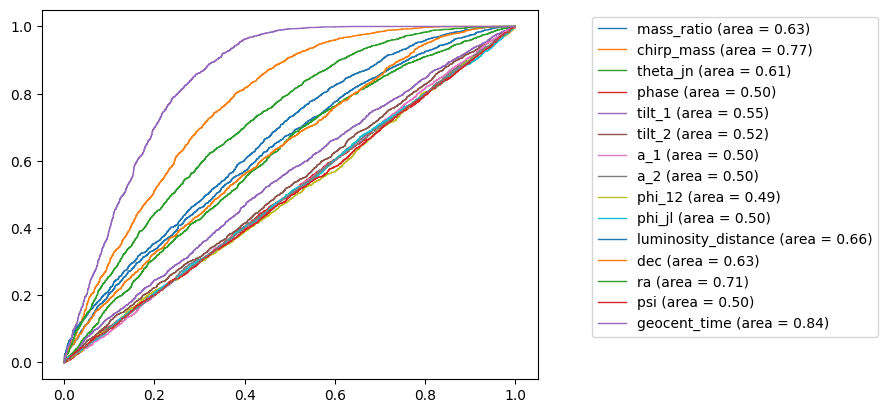



Training: 100%|██████████| 2/2 [04:36<00:00, 138.18s/it]


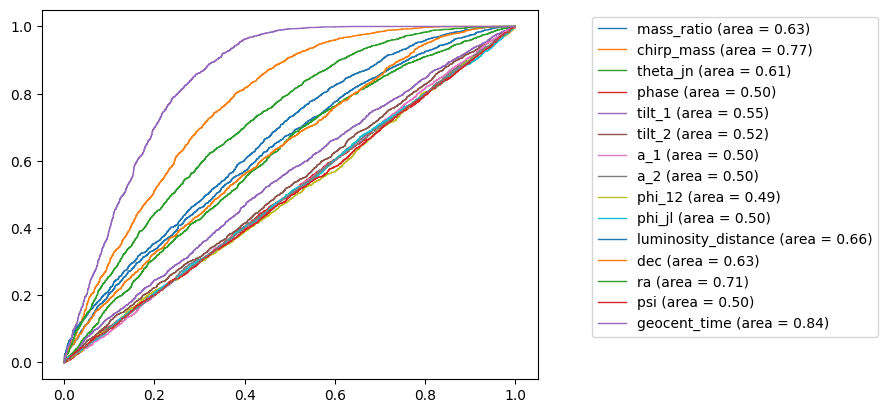

In [104]:
# Start manual training (without pytorch trainer)
from tqdm import tqdm, trange
import torch.optim as optim
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from IPython import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network.to(device)

optimizer = optim.Adam(network.parameters(), lr=LR)

# Training loop

for epoch in trange(N_EPOCHS, desc="Training"):
    
    train_loss = []
    for batch in tqdm(train_data, desc=f"Epoch {epoch + 1} in training", leave=True):
        
        batch = {key:batch[key].to(device) for key in batch}
        loss = network.training_step(batch, 0)

        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    with torch.no_grad():
        
        logratios = []
        probabilities = []
        labels = []
        
        val_loss = []
        for batch in tqdm(val_data, desc="Validation", leave=False):
            
            batch = {key:batch[key].to(device) for key in batch}
            loss = network.validation_step(batch, 0)

            val_loss.append(loss.item())
        
            logratios_probs = network.get_logratios_probabilities(batch)
            logratios.append(logratios_probs[0])
            probabilities.append(logratios_probs[1])
            labels.append(logratios_probs[2])
         
            logratios_np = torch.concat(logratios).detach().cpu().numpy()
            probabilities_np = torch.concat(probabilities).detach().cpu().numpy()
            labels_np = torch.concat(labels).cpu().numpy()
            
            plt.close()
            display.clear_output(wait=True)
            
            print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {sum(train_loss)/len(train_loss):.2f}")
            print(f"Validation loss: {sum(val_loss)/len(val_loss):.2f}")
            
            plt.figure(1)
            plt.clf()
            
            for i, name in enumerate(intrinsic_variables+extrinsic_variables):
                fpr, tpr, thresholds = roc_curve(labels_np[:,i], probabilities_np[:,i])
                roc_auc = auc(fpr, tpr)
                
                #print (f'{name} {roc_auc:.2f}')
                plt.plot(fpr, tpr, lw=1, label=f'{name} (area = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], color='grey', lw=0.5, linestyle='--')
            plt.legend(bbox_to_anchor=(1.7, 1), loc="upper right")
            display.display(plt.gcf())


        